In [20]:
import plot_show

Loading BokehJS ...

bic: -156176.082385 p: 1 q: 2
[ -1.02505923e-05]


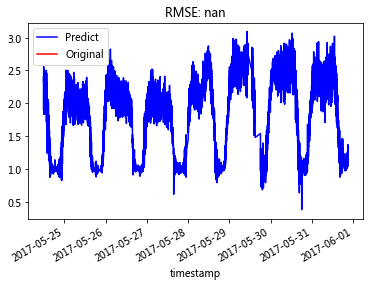

In [4]:
import warnings
warnings.filterwarnings('ignore')
from math import sqrt
import pandas as pd
import numpy as np
from statsmodels.tsa.arima_model import ARMA
import sys
from dateutil.relativedelta import relativedelta
from copy import deepcopy
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

class arima_model:

    def __init__(self, ts, maxLag=9):
        self.data_ts = ts
        self.resid_ts = None
        self.predict_ts = None
        self.maxLag = maxLag
        self.p = maxLag
        self.q = maxLag
        self.properModel = None
        self.bic = 99999

    # 计算最优ARIMA模型，将相关结果赋给相应属性
    def get_proper_model(self):
        self._proper_model()
        self.predict_ts = deepcopy(self.properModel.predict())
        self.resid_ts = deepcopy(self.properModel.resid)

    # 对于给定范围内的p,q计算拟合得最好的arima模型，这里是对差分好的数据进行拟合，故差分恒为0
    def _proper_model(self):
        for p in np.arange(self.maxLag):
            for q in np.arange(self.maxLag):
                # print p,q,self.bic
                model = ARMA(self.data_ts, order=(p, q))
                try:
                    results_ARMA = model.fit(disp=-1, method='css')
                except:
                    continue
                bic = results_ARMA.bic
                # print 'bic:',bic,'self.bic:',self.bic
                if bic < self.bic:
                    self.p = p
                    self.q = q
                    self.properModel = results_ARMA
                    self.bic = bic
                    self.resid_ts = deepcopy(self.properModel.resid)
                    self.predict_ts = self.properModel.predict()

    # 参数确定模型
    def certain_model(self, p, q):
            model = ARMA(self.data_ts, order=(p, q))
            try:
                self.properModel = model.fit( disp=-1, method='css')
                self.p = p
                self.q = q
                self.bic = self.properModel.bic
                self.predict_ts = self.properModel.predict()
                self.resid_ts = deepcopy(self.properModel.resid)
            except:
                print ('You can not fit the model with this parameter p,q, ' \
                      'please use the get_proper_model method to get the best model')

    # 预测第二日的值
    def forecast_next_day_value(self, type='day'):
        # 我修改了statsmodels包中arima_model的源代码，添加了constant属性，需要先运行forecast方法，为constant赋值
        self.properModel.forecast()
        if self.data_ts.index[-1] != self.resid_ts.index[-1]:
            raise ValueError('''The index is different in data_ts and resid_ts, please add new data to data_ts.
            If you just want to forecast the next day data without add the real next day data to data_ts,
            please run the predict method which arima_model included itself''')
        if not self.properModel:
            raise ValueError('The arima model have not computed, please run the proper_model method before')
        para = self.properModel.params

        # print self.properModel.params
        if self.p == 0:   # It will get all the value series with setting self.data_ts[-self.p:] when p is zero
            ma_value = self.resid_ts[-self.q:]
            values = ma_value.reindex(index=ma_value.index[::-1])
        elif self.q == 0:
            ar_value = self.data_ts[-self.p:]
            values = ar_value.reindex(index=ar_value.index[::-1])
        else:
            ar_value = self.data_ts[-self.p:]
            ar_value = ar_value.reindex(index=ar_value.index[::-1])
            ma_value = self.resid_ts[-self.q:]
            ma_value = ma_value.reindex(index=ma_value.index[::-1])
            values = ar_value.append(ma_value)

        predict_value = np.dot(para[1:], values) + self.properModel.constant[0]
        self._add_new_data(self.predict_ts, predict_value, type)
        return predict_value

    # 动态添加数据函数，针对索引是月份和日分别进行处理
    def _add_new_data(self, ts, dat, type='day'):
        if type == 'day':
            new_index = ts.index[-1] + relativedelta(days=1)
        elif type == 'month':
            new_index = ts.index[-1] + relativedelta(months=1)
        ts[new_index] = dat

    def add_today_data(self, dat, type='day'):
        self._add_new_data(self.data_ts, dat, type)
        if self.data_ts.index[-1] != self.predict_ts.index[-1]:
            raise ValueError('You must use the forecast_next_day_value method forecast the value of today before')
        self._add_new_data(self.resid_ts, self.data_ts[-1] - self.predict_ts[-1], type)

if __name__ == '__main__':
    df = pd.read_csv("../data/one_train_denoised_7day.csv",sep=',')
    df.set_index('timestamp',inplace=True,drop=True)
    ts = df['value']

    # 数据预处理
    rol_mean = ts.rolling(window=24*60).mean()
    rol_mean.dropna(inplace=True)
    ts_diff_1 = rol_mean.diff(1)
    ts_diff_1.dropna(inplace=True)
    ts_diff_2 = ts_diff_1.diff(1)
    ts_diff_2.dropna(inplace=True)

    # 模型拟合
    model = arima_model(ts_diff_2)
    #  这里使用模型参数自动识别
    model.get_proper_model()
    print ('bic:', model.bic, 'p:', model.p, 'q:', model.q)
    print (model.properModel.forecast()[0])

    # 预测结果还原
    predict_ts = model.properModel.predict()
    diff_shift_ts = ts_diff_1.shift(1)
    diff_recover_1 = predict_ts.add(diff_shift_ts)
    rol_shift_ts = rol_mean.shift(1)
    diff_recover = diff_recover_1.add(rol_shift_ts)
    rol_sum = ts.rolling(window=24*60-1).sum()
    rol_recover = diff_recover*24*60 - rol_sum.shift(1)
    rol_recover.dropna(inplace=True)

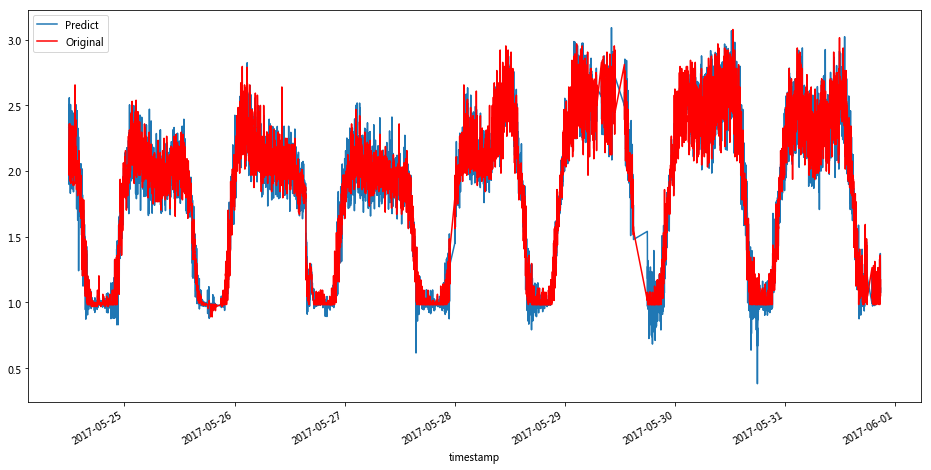

In [47]:
df = pd.read_csv("../data/one_train_denoised_7day.csv",sep=',')
df['timestamp'] = pd.to_datetime(df.timestamp)
df.set_index('timestamp',inplace=True,drop=True)
my_ts = df['value']
my_ts = my_ts[rol_recover.index]
plt.figure(facecolor='white',figsize=(16,8))
rol_recover.plot( label='Predict')
my_ts.plot(color='red', label='Original')
plt.legend(loc='best')
# plt.title('RMSE: %.4f'% mean_squared_error(rol_recover,my_ts))
plt.show()

In [ ]:
rol_recover
my_ts = df['value'][60*5:3*24*60+60*5]
my_ts = my_ts[rol_recover.index]
plt.figure(facecolor='white',figsize=(16,8))
rol_recover.plot(color='blue', label='Predict')
my_ts.plot(color='red', label='Original')
plt.legend(loc='best')
plt.title('RMSE: %.4f'% mean_squared_error(rol_recover,my_ts))
plt.show()

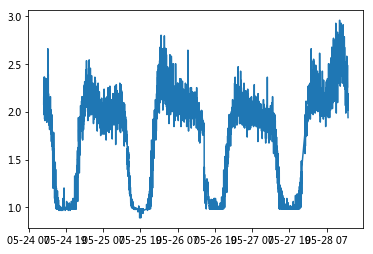

In [50]:
plt.plot(my_ts[:4*24*60])
plt.show()

In [51]:
print('RMSE: %.4f'% mean_squared_error(rol_recover,my_ts))

RMSE: 0.0225
